In [1]:
import math
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple

In [2]:
SEED = 42

def set_seed(seed=SEED):
    # NumPy
    np.random.seed(seed)
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

In [3]:
from lunar_lander import LunarLander
from wrapper import NonCausalInternalLunarLanderObsWrapper
base_env = LunarLander(enable_wind=False)
env_1 = NonCausalInternalLunarLanderObsWrapper(base_env, scale=1.0, noise_level=0.01)
env_2 = NonCausalInternalLunarLanderObsWrapper(base_env, scale=1.0, noise_level=0.01)
env_3 = NonCausalInternalLunarLanderObsWrapper(base_env, scale=1.0, noise_level=0.01)
envs = [env_1, env_2, env_3]
for i_env in envs:
    i_env.reset(seed=SEED)
test_env_1 = NonCausalInternalLunarLanderObsWrapper(base_env, scale=0.0, noise_level=0.0)  # No noise
test_env_2 = NonCausalInternalLunarLanderObsWrapper(base_env, scale=1.0, noise_level=0.0) # Within range but not trained
test_env_3 = NonCausalInternalLunarLanderObsWrapper(base_env, scale=1.0, noise_level=0.0)  # Out of range
test_envs = [test_env_1, test_env_2, test_env_3]
for i_env in test_envs:
    i_env.reset(seed=SEED)

In [4]:
state_shape = envs[0].observation_space.shape[0]
action_shape = envs[0].action_space.n

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BUFFER_SIZE = 100000  # Replay memory size
BATCH_SIZE = 64       # Minibatch size
GAMMA = 0.99          # Discount factor
TAU = 1e-3            # Soft update of target parameters
LR = 5e-4             # Learning rate
UPDATE_EVERY = 5      # How often to update the network
N_EPOCHS = 5      
# Training parameters
n_episodes = 3000
max_t = 1000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995
recurrent = False

Using device: cuda


In [5]:
from agent import Agent

agent = Agent(state_size=state_shape, action_size=action_shape, device=device,
        recurrent=recurrent, lr=LR, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA,
        tau=TAU, update_every=UPDATE_EVERY, n_epochs=N_EPOCHS)

Initializing Vanilla DQN Agent (MLP)...
DeepQNetwork(
  (fc1): Linear(in_features=19, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


In [6]:
n_envs = len(envs)
n_test_envs = len(test_envs)

train_returns = [[] for _ in range(n_envs)]
scores_window = [deque(maxlen=100) for _ in range(n_envs)]
train_mean_returns = [[] for _ in range(n_envs)]  # avg value during training rollout

env_eval_returns  = [[] for _ in range(n_envs)]
test_eval_returns = [[] for _ in range(n_test_envs)]

eps = eps_start
print("Training started...")
for i_episode in range(1, n_episodes + 1):
    states = []
    hiddens = []
    dones = [False] * n_envs
    episode_scores = np.zeros(n_envs, dtype=np.float32)
    for env in envs:
        s, _ = env.reset()
        states.append(s)
        hiddens.append(agent.qnetwork_local.init_hidden(1))
    # --- rollout ---
    for t in range(max_t):
        for i, env in enumerate(envs):
            if dones[i]:
                continue
            action, next_hidden = agent.act(states[i], eps, hiddens[i])
            next_state, reward, done, truncated, _ = env.step(action)
            terminal = done or truncated
            agent.step(
                states[i], action, reward,
                next_state, terminal,
                hiddens[i], next_hidden
            )
            states[i] = next_state
            hiddens[i] = next_hidden
            episode_scores[i] += reward
            dones[i] = terminal
        if all(dones):
            break

    for i in range(n_envs):
        ep_ret = float(episode_scores[i])
        train_returns[i].append(ep_ret)
        scores_window[i].append(ep_ret)
        train_mean_returns[i].append(np.mean(scores_window[i]))

    eps = max(eps_end, eps_decay * eps)
    env_stats = " | ".join(
        f"Env{i}: {np.mean(scores_window[i]):.2f}"
        for i in range(n_envs)
    )
    print(
        f"\rEpisode {i_episode}"
        f"\t{env_stats}"
        f"\tEps: {eps:.3f}",
        end=""
    )

    if i_episode % 10 == 0:
        for i, env in enumerate(envs):
            eval_list = []
            for _ in range(5):
                state, _ = env.reset()
                hidden = agent.qnetwork_local.init_hidden(1)
                total = 0.0

                for t in range(max_t):
                    action, next_hidden = agent.act(state, eps=0.0, hidden=hidden)
                    next_state, reward, done, truncated, _ = env.step(action)
                    state = next_state
                    hidden = next_hidden
                    total += reward
                    if done or truncated:
                        break
                eval_list.append(total)
            env_eval_returns[i].append(float(np.mean(eval_list)))
             
        for i, env in enumerate(test_envs):
            eval_list = []
            for _ in range(5):
                state, _ = env.reset()
                hidden = agent.qnetwork_local.init_hidden(1)
                total = 0.0
                for t in range(max_t):
                    action, next_hidden = agent.act(
                        state, eps=0.0, hidden=hidden
                    )
                    next_state, reward, done, truncated, _ = env.step(action)
                    state = next_state
                    hidden = next_hidden
                    total += reward
                    if done or truncated:
                        break
                eval_list.append(total)
            test_eval_returns[i].append(np.mean(eval_list))
    # --- clean newline every 100 eps ---
    if i_episode % 100 == 0:
        print("\n" + "-" * 90)
        print(f"Episode {i_episode}")
        for i in range(n_envs):
            line = f"  Env{i}: Train Avg(100)={np.mean(scores_window[i]):.2f}"
            if env_eval_returns[i]:
                line += f" | Eval={env_eval_returns[i][-1]:.2f}"
            print(line)

        for i in range(n_test_envs):
            print(f"  TestEnv{i}: Test Eval={test_eval_returns[i][-1]:.2f}")

Training started...
Episode 100	Env0: -114.39 | Env1: -118.53 | Env2: -120.30	Eps: 0.606
------------------------------------------------------------------------------------------
Episode 100
  Env0: Train Avg(100)=-114.39 | Eval=-326.61
  Env1: Train Avg(100)=-118.53 | Eval=-263.15
  Env2: Train Avg(100)=-120.30 | Eval=-247.34
  TestEnv0: Test Eval=-107.33
  TestEnv1: Test Eval=-199.26
  TestEnv2: Test Eval=-198.03
Episode 200	Env0: -113.54 | Env1: -97.82 | Env2: -99.25	Eps: 0.36706
------------------------------------------------------------------------------------------
Episode 200
  Env0: Train Avg(100)=-113.54 | Eval=-133.71
  Env1: Train Avg(100)=-97.82 | Eval=-203.65
  Env2: Train Avg(100)=-99.25 | Eval=-153.26
  TestEnv0: Test Eval=-139.46
  TestEnv1: Test Eval=-140.37
  TestEnv2: Test Eval=-158.01
Episode 300	Env0: -65.46 | Env1: -52.37 | Env2: -53.35	Eps: 0.2226
------------------------------------------------------------------------------------------
Episode 300
  Env0: Trai

KeyboardInterrupt: 

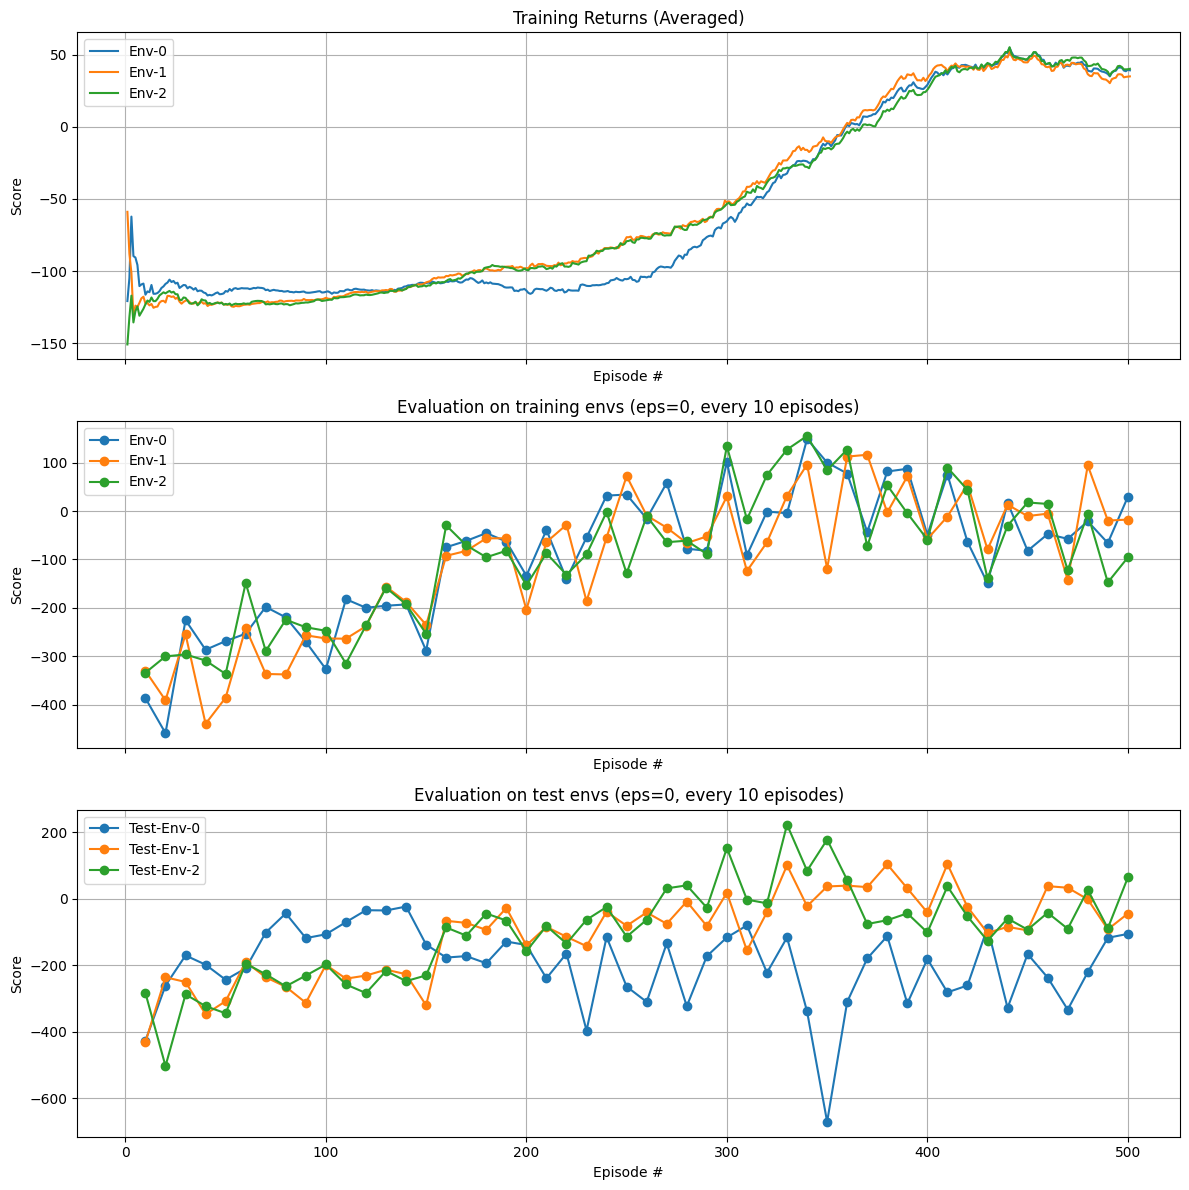

In [7]:
n_envs = len(envs)
n_test_envs = len(test_envs)

eval_every = 10  # you evaluate every 10 episodes

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# --- Training scores ---
for i in range(n_envs):
    x = np.arange(1, len(train_mean_returns[i]) + 1)
    ax1.plot(x, train_mean_returns[i], label=f'Env-{i}')
    
ax1.set_ylabel('Score')
ax1.set_xlabel('Episode #')
ax1.set_title('Training Returns (Averaged)')
ax1.grid(True)
ax1.legend(ncol=1)

for i in range(n_envs):
    eval_x = np.arange(1, len(env_eval_returns[i]) + 1) * eval_every
    ax2.plot(
        eval_x,
        env_eval_returns[i],
        marker='o',
        linestyle='-',
        label=f'Env-{i}'
    )

ax2.set_ylabel('Score')
ax2.set_xlabel('Episode #')
ax2.set_title(f'Evaluation on training envs (eps=0, every {eval_every} episodes)')
ax2.grid(True)
ax2.legend(ncol=1)

for i in range(n_test_envs):
    eval_test_x = np.arange(1, len(test_eval_returns[i]) + 1) * eval_every
    ax3.plot(
        eval_test_x,
        test_eval_returns[i],
        marker='o',
        linestyle='-',
        label=f'Test-Env-{i}'
    )

ax3.set_ylabel('Score')
ax3.set_xlabel('Episode #')
ax3.set_title(f'Evaluation on test envs (eps=0, every {eval_every} episodes)')
ax3.grid(True)
ax3.legend(ncol=1)

plt.tight_layout()
plt.show()

In [8]:
from buffers import ReplayBuffer, HiddenStateReplayBuffer
from agent import Agent

buffers = [
    HiddenStateReplayBuffer(
        action_size=action_shape,
        buffer_size=BUFFER_SIZE,
        batch_size=BATCH_SIZE,
        device=device
    ) if recurrent else ReplayBuffer(
        action_size=action_shape,
        buffer_size=BUFFER_SIZE,
        batch_size=BATCH_SIZE,
        device=device
    )
    for _ in envs
]
group_weights = torch.tensor([0.5 for i in envs]) # Start with equal weighting for env_1 and env_2

dro_agent = Agent(state_size=state_shape, action_size=action_shape, device=device,
        recurrent=recurrent, lr=LR, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA,
        tau=TAU, update_every=UPDATE_EVERY, n_epochs=N_EPOCHS)

Initializing Vanilla DQN Agent (MLP)...
DeepQNetwork(
  (fc1): Linear(in_features=19, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


In [9]:
def learn(agent, experiences):
    """Update value parameters using given batch of experience tuples."""
    if agent.recurrent:
        states, actions, rewards, next_states, dones, hidden, next_hidden = experiences
    else:
        states, actions, rewards, next_states, dones = experiences

    # ------------------- Compute Target Q ------------------- #
    with torch.no_grad():
        if agent.recurrent:
            # Double DQN for LSTM:
            # 1. Select best action using Local Net + Next Hidden State
            local_next_out, _ = agent.qnetwork_local(next_states, next_hidden)
            best_actions = local_next_out.argmax(1).unsqueeze(1)
            
            # 2. Evaluate using Target Net + Next Hidden State
            target_next_out, _ = agent.qnetwork_target(next_states, next_hidden)
            Q_targets_next = target_next_out.gather(1, best_actions)
        else:
            # Double DQN for MLP:
            best_actions = agent.qnetwork_local(next_states).argmax(1).unsqueeze(1)
            Q_targets_next = agent.qnetwork_target(next_states).gather(1, best_actions)
        Q_targets = rewards + (agent.gamma * Q_targets_next * (1 - dones))


    if agent.recurrent:
        # Forward pass with the STORED hidden state from the buffer
        current_out, _ = agent.qnetwork_local(states, hidden)
        Q_expected = current_out.gather(1, actions)
    else:
        Q_expected = agent.qnetwork_local(states).gather(1, actions)

    # Compute loss
    loss = F.smooth_l1_loss(Q_expected, Q_targets)
    return loss

In [10]:
n_envs = len(envs)
n_test_envs = len(test_envs)

train_returns = [[] for _ in range(n_envs)]
scores_window = [deque(maxlen=100) for _ in range(n_envs)]
train_mean_returns = [[] for _ in range(n_envs)]  # avg value during training rollout

env_eval_returns  = [[] for _ in range(n_envs)]
test_eval_returns = [[] for _ in range(n_test_envs)]

eps = eps_start
t_step = 0
print("Training started...")
for i_episode in range(1, n_episodes + 1):
    states = []
    hiddens = []
    dones = [False] * n_envs
    episode_scores = np.zeros(n_envs, dtype=np.float32)
    for env in envs:
        s, _ = env.reset()
        states.append(s)
        hiddens.append(dro_agent.qnetwork_local.init_hidden(1))
    # --- rollout ---
    for t in range(max_t):
        for i, env in enumerate(envs):
            if dones[i]:
                continue
            action, next_hidden = dro_agent.act(states[i], eps, hiddens[i])
            next_state, reward, done, truncated, _ = env.step(action)
            terminal = done or truncated

            if recurrent:
                buffers[i].add(states[i], action, reward, next_state, terminal, hiddens[i], next_hidden)
            else:
                buffers[i].add(states[i], action, reward, next_state, terminal)

            states[i] = next_state
            hiddens[i] = next_hidden
            episode_scores[i] += reward
            dones[i] = terminal
        
        # Train step
        t_step += 1
        if all([len(i) > dro_agent.batch_size for i in buffers]):
            t_step = (t_step + 1) % dro_agent.update_every
            if t_step == 0:
                losses = []
                for i, env in enumerate(envs):
                    experience = buffers[i].sample()
                    loss_i = learn(dro_agent, experience)
                    losses.append(loss_i)

                loss = max(losses)
                dro_agent.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(dro_agent.qnetwork_local.parameters(), 1.0)
                dro_agent.optimizer.step()
                
                dro_agent.soft_update(dro_agent.qnetwork_local, dro_agent.qnetwork_target, dro_agent.tau)

        if all(dones):
            break
        
    for i in range(n_envs):
        ep_ret = float(episode_scores[i])
        train_returns[i].append(ep_ret)
        scores_window[i].append(ep_ret)
        train_mean_returns[i].append(np.mean(scores_window[i]))

    eps = max(eps_end, eps_decay * eps)
    env_stats = " | ".join(
        f"Env{i}: {np.mean(scores_window[i]):.2f}"
        for i in range(n_envs)
    )
    print(
        f"\rEpisode {i_episode}"
        f"\t{env_stats}"
        f"\tEps: {eps:.3f}",
        end=""
    )

    if i_episode % 10 == 0:
        for i, env in enumerate(envs):
            eval_list = []
            for _ in range(5):
                state, _ = env.reset()
                hidden = dro_agent.qnetwork_local.init_hidden(1)
                total = 0.0

                for t in range(max_t):
                    action, next_hidden = dro_agent.act(state, eps=0.0, hidden=hidden)
                    next_state, reward, done, truncated, _ = env.step(action)
                    state = next_state
                    hidden = next_hidden
                    total += reward
                    if done or truncated:
                        break
                eval_list.append(total)
            env_eval_returns[i].append(float(np.mean(eval_list)))
            
        for i, env in enumerate(test_envs):
            eval_list = []
            for _ in range(5):
                state, _ = env.reset()
                hidden = dro_agent.qnetwork_local.init_hidden(1)
                total = 0
                for t in range(max_t):
                    action, next_hidden = dro_agent.act(
                        state, eps=0.0, hidden=hidden
                    )
                    next_state, reward, done, truncated, _ = env.step(action)
                    state = next_state
                    hidden = next_hidden
                    total += reward
                    if done or truncated:
                        break
                eval_list.append(total)
            test_eval_returns[i].append(np.mean(eval_list))
    # --- clean newline every 100 eps ---
    if i_episode % 100 == 0:
        print("\n" + "-" * 90)
        print(f"Episode {i_episode}")
        for i in range(n_envs):
            line = f"  Env{i}: Train Avg(100)={np.mean(scores_window[i]):.2f}"
            if env_eval_returns[i]:
                line += f" | Eval={env_eval_returns[i][-1]:.2f}"
            print(line)

        for i in range(n_test_envs):
            print(f"  TestEnv{i}: Test Eval={test_eval_returns[i][-1]:.2f}")

Training started...
Episode 100	Env0: -124.17 | Env1: -125.04 | Env2: -124.93	Eps: 0.606
------------------------------------------------------------------------------------------
Episode 100
  Env0: Train Avg(100)=-124.17 | Eval=-226.22
  Env1: Train Avg(100)=-125.04 | Eval=-237.32
  Env2: Train Avg(100)=-124.93 | Eval=-307.91
  TestEnv0: Test Eval=-121.41
  TestEnv1: Test Eval=-282.42
  TestEnv2: Test Eval=-232.21
Episode 200	Env0: -112.57 | Env1: -116.40 | Env2: -110.41	Eps: 0.367
------------------------------------------------------------------------------------------
Episode 200
  Env0: Train Avg(100)=-112.57 | Eval=-269.56
  Env1: Train Avg(100)=-116.40 | Eval=-448.37
  Env2: Train Avg(100)=-110.41 | Eval=-326.31
  TestEnv0: Test Eval=-348.00
  TestEnv1: Test Eval=-389.45
  TestEnv2: Test Eval=-293.68
Episode 300	Env0: -58.18 | Env1: -53.28 | Env2: -51.96	Eps: 0.222696
------------------------------------------------------------------------------------------
Episode 300
  Env0: 

KeyboardInterrupt: 

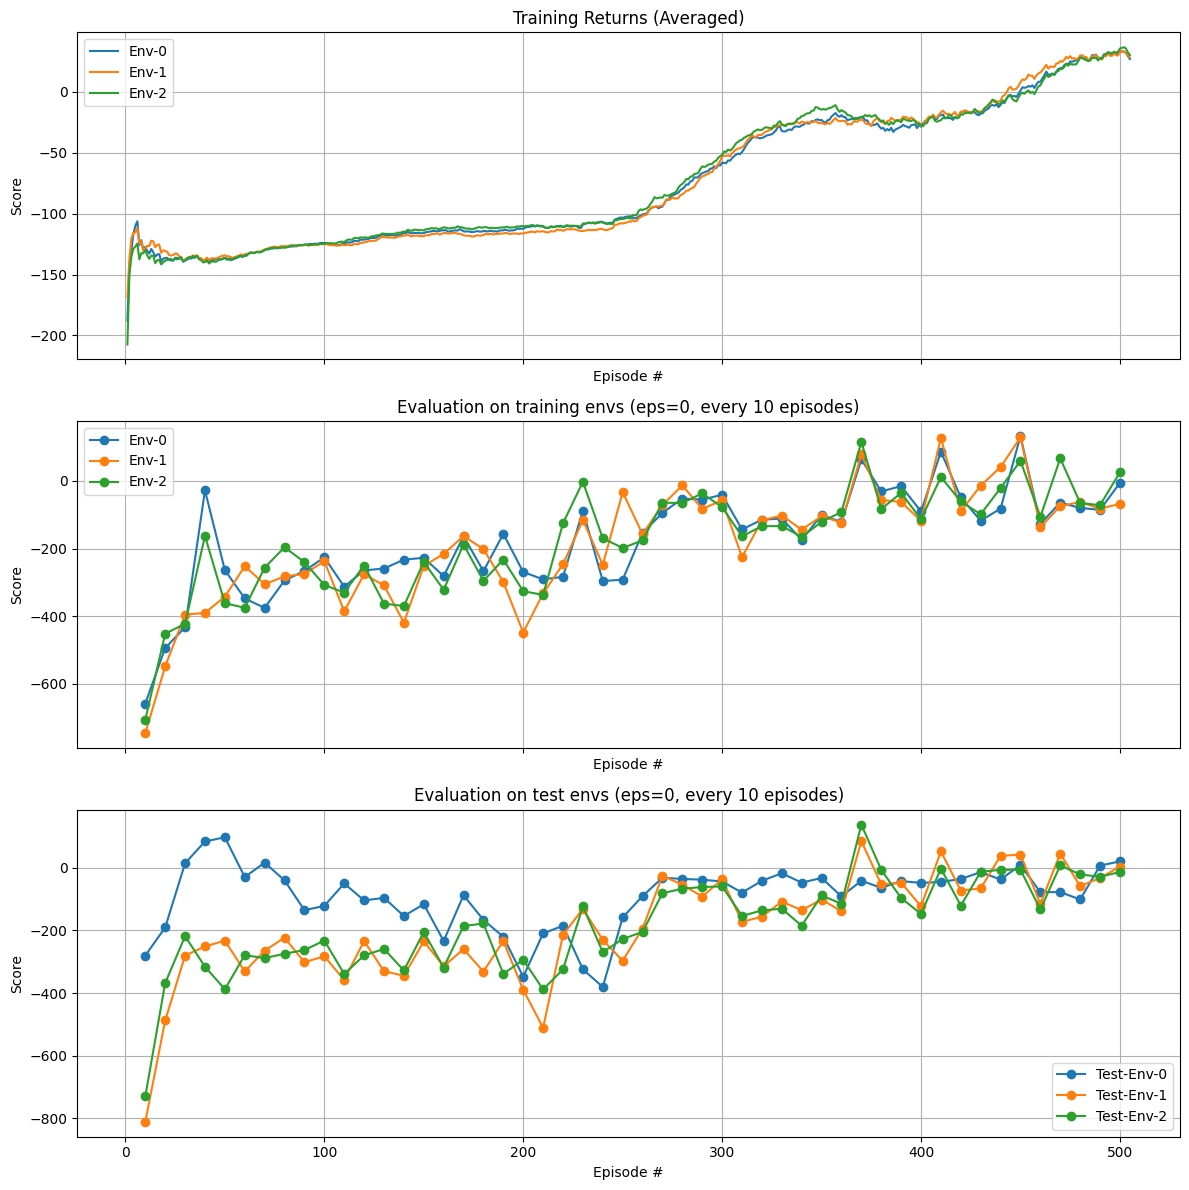

In [11]:
n_envs = len(envs)
n_test_envs = len(test_envs)

eval_every = 10  # you evaluate every 10 episodes

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# --- Training scores ---
for i in range(n_envs):
    x = np.arange(1, len(train_mean_returns[i]) + 1)
    ax1.plot(x, train_mean_returns[i], label=f'Env-{i}')
    
ax1.set_ylabel('Score')
ax1.set_xlabel('Episode #')
ax1.set_title('Training Returns (Averaged)')
ax1.grid(True)
ax1.legend(ncol=1)

for i in range(n_envs):
    eval_x = np.arange(1, len(env_eval_returns[i]) + 1) * eval_every
    ax2.plot(
        eval_x,
        env_eval_returns[i],
        marker='o',
        linestyle='-',
        label=f'Env-{i}'
    )

ax2.set_ylabel('Score')
ax2.set_xlabel('Episode #')
ax2.set_title(f'Evaluation on training envs (eps=0, every {eval_every} episodes)')
ax2.grid(True)
ax2.legend(ncol=1)

for i in range(n_test_envs):
    eval_test_x = np.arange(1, len(test_eval_returns[i]) + 1) * eval_every
    ax3.plot(
        eval_test_x,
        test_eval_returns[i],
        marker='o',
        linestyle='-',
        label=f'Test-Env-{i}'
    )

ax3.set_ylabel('Score')
ax3.set_xlabel('Episode #')
ax3.set_title(f'Evaluation on test envs (eps=0, every {eval_every} episodes)')
ax3.grid(True)
ax3.legend(ncol=1)

plt.tight_layout()
plt.show()

In [ ]:
# # We want weights to increase for the higher loss
#             with torch.no_grad():
#                 losses = torch.tensor([loss_1.item(), loss_2.item()])
#                 # Update weights: w_i = w_i * exp(eta * loss_i)
#                 group_weights = group_weights * torch.exp(DRO_STEP_SIZE * losses)
#                 # Normalize so they sum to 1
#                 group_weights = group_weights / group_weights.sum()

#             # 4. Compute Weighted Robust Loss
#             # Weighted sum based on adversarial weights
#             robust_loss = group_weights[0] * loss_1 + group_weights[1] * loss_2